In [1]:
%set_env OMP_NUM_THREADS=1

env: OMP_NUM_THREADS=1


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus
import dedalus.public as d3
import logging
import h5py
logger = logging.getLogger(__name__)

# Solving the Stokes equation on a torus

Initial time = [-10   5  15]


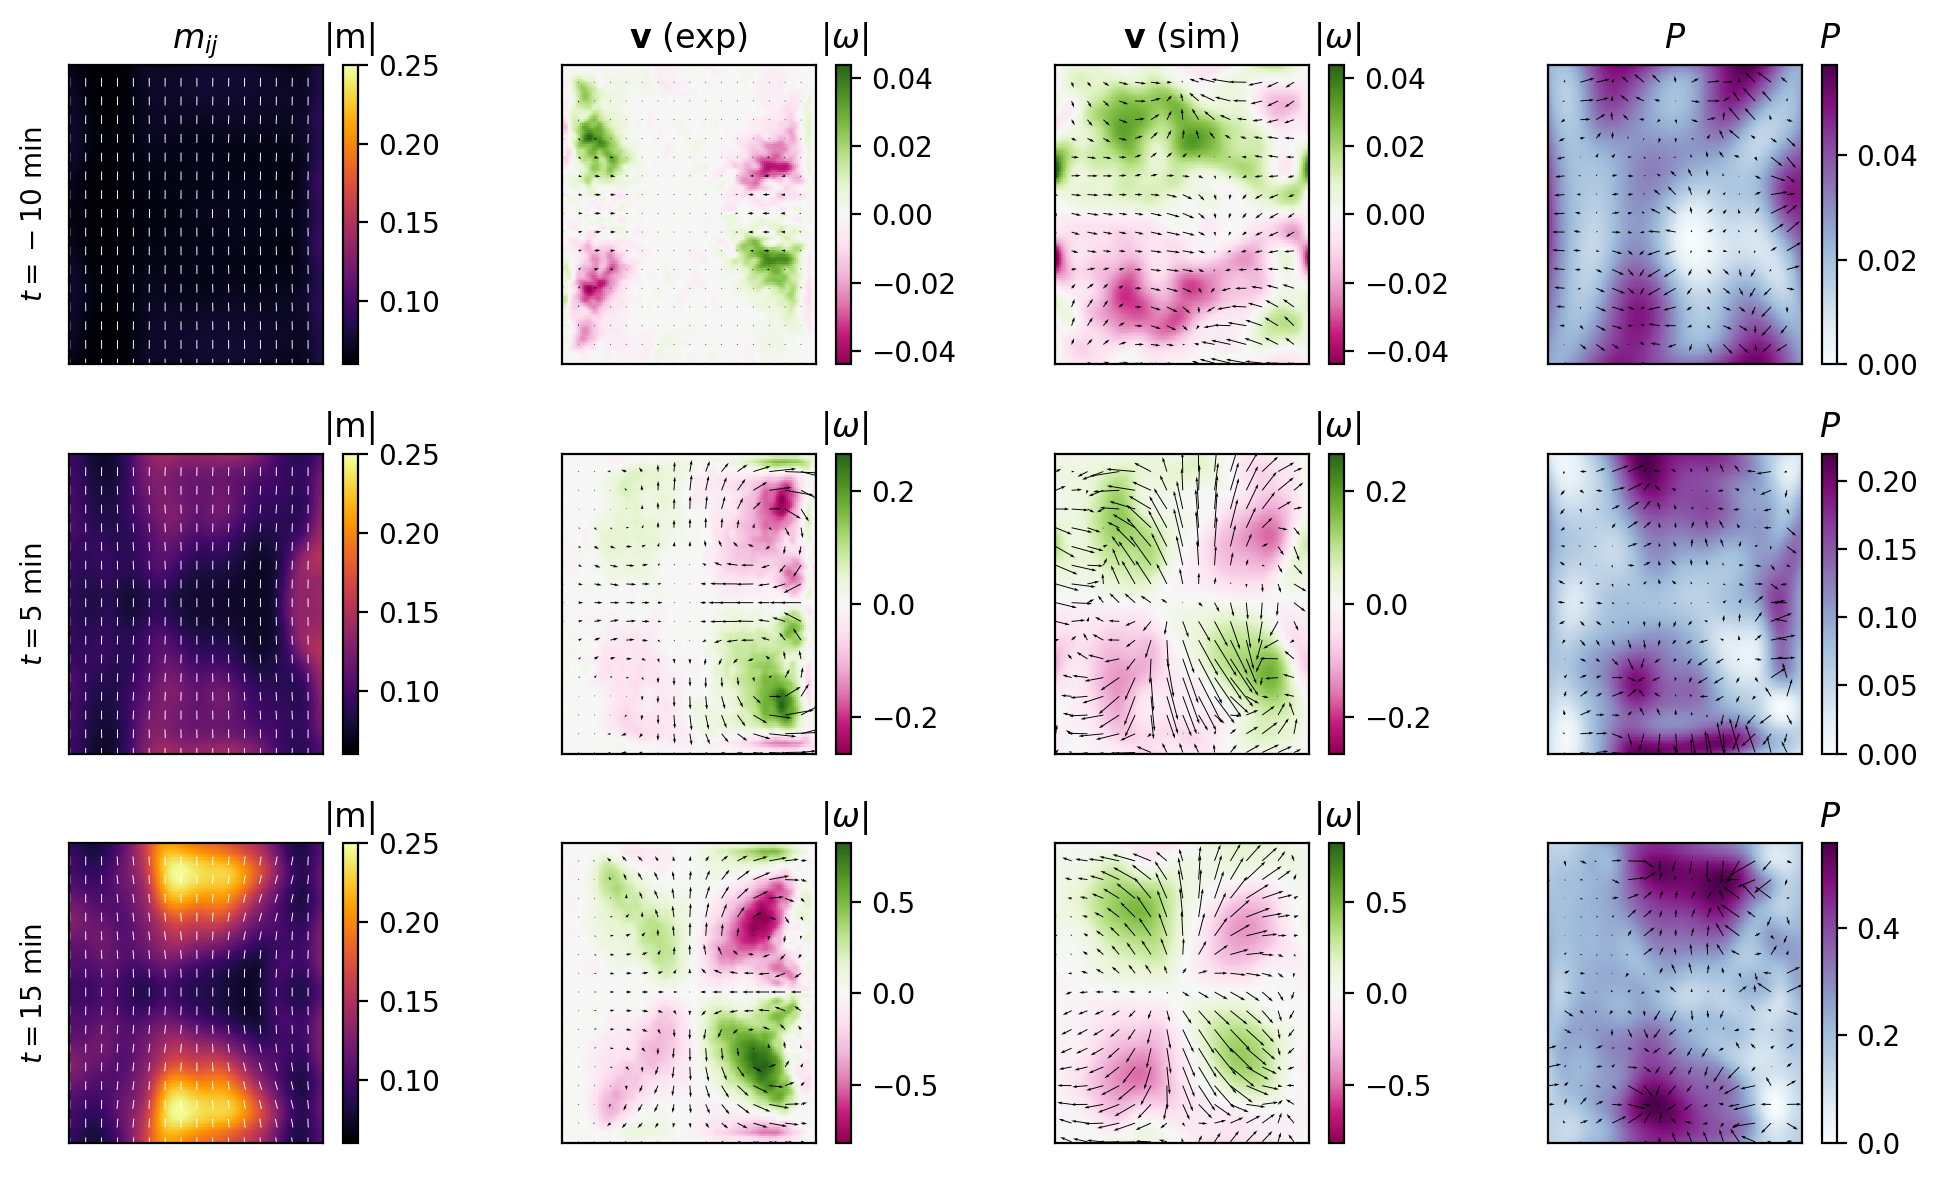

In [28]:
from scipy.interpolate import RectBivariateSpline
folder = '../../test_data'
tt = [0, 15, 25]
t0 = np.load(f'{folder}/time.npy')
print(f'Initial time = {t0[tt]}')
m0 = np.load(f'{folder}/myosin.npy', mmap_mode='r')[tt]
v0 = np.load(f'{folder}/velocity.npy', mmap_mode='r')[tt]
p0 = np.load('PINN_pressure.npy', mmap_mode='r')[tt]

logging.getLogger('subsystems').setLevel('ERROR')

def get_g_with_scales(field, scales):
    f = field.copy()
    f.change_scales(scales)
    return f["g"]

Lx, Ly = 452., 533.
Nx, Ny = 128, 128

dealias = 3/2
mu, α = 1, 3.9

# Bases
coords = d3.CartesianCoordinates("x", "y")
dist = d3.Distributor(coords, dtype=np.float64)
xbasis = d3.RealFourier(  coords["x"], size=Nx, bounds=(-Lx/2,Lx/2), dealias=dealias)
ybasis = d3.RealFourier(coords["y"], size=Ny, bounds=(-Ly/2,Ly/2), dealias=dealias)
x1, y1 = dist.local_grids(xbasis, ybasis)
x0 = np.linspace(-Lx/2, Lx/2, m0.shape[-1])
y0 = np.linspace(-Ly/2, Ly/2, m0.shape[-2])
x = np.squeeze(xbasis.local_grid())
y = np.squeeze(ybasis.local_grid())

# Plot
fig, ax = plt.subplots(len(tt), 4, dpi=200, figsize=(10, 2*len(tt)))

# Forcing conditions
for i, t in enumerate(tt):
    # Fields
    v = dist.VectorField(coords, name="v", bases=(xbasis,ybasis))
    m = dist.TensorField(coords, name="m", bases=(xbasis,ybasis))
    p = dist.ScalarField(name='p', bases=(xbasis,ybasis))
    tau_v = dist.VectorField(coords, name='tau_v') #Residual for velocity
    
    m["g"][0,0,:,:] = RectBivariateSpline(x0, y0, m0[i, 3].T)(x1, y1)
    m["g"][0,1,:,:] = RectBivariateSpline(x0, y0, m0[i, 1].T)(x1, y1)
    m["g"][1,0,:,:] = m['g'][0,1,:,:]
    m["g"][1,1,:,:] = RectBivariateSpline(x0, y0, m0[i, 0].T)(x1, y1)
    p['g'][:] = RectBivariateSpline(x0, y0, p0[i].T)(x1, y1)
    vx = RectBivariateSpline(x0, y0, v0[i, 1].T)(x1, y1)
    vy = RectBivariateSpline(x0, y0, v0[i, 0].T)(x1, y1)

    #Static velocity Problem
    problem = d3.LBVP([v, tau_v], namespace=locals())
    problem.add_equation("mu*lap(v) + tau_v = grad(p) - α * div(m) ") # Stokes equation (with tau residual)
    problem.add_equation("integ(v) = 0")   #No net flow gauge
    
    # Solver
    solver = problem.build_solver()
    solver.solve()

    pt = get_g_with_scales(p, (1, 1))
    vi = get_g_with_scales(v, (1, 1))
    mij = get_g_with_scales(m, (1, 1))

    mij = mij.transpose(2, 3, 0, 1)
    mkk = np.linalg.norm(mij, axis=(2, 3))
    el, ev = np.linalg.eigh(mij) #Positive eigenvalue is n
    n = ev[..., 1]

    pcM = ax[i, 0].pcolormesh(x, y, mkk.T, cmap='inferno', vmin=0.06, vmax=0.25)
    skip = 8
    scale = 1e2 if t0[t] > 10 else 2e1
    X, Y = np.meshgrid(x.flatten()[::skip], y.flatten()[::skip])
    ax[i, 0].quiver(X, Y, n[::skip, ::skip, 0].T, n[::skip, ::skip, 1].T,
                 pivot='middle', color='white',
                 headwidth=0, headlength=0, headaxislength=0)

    cb = plt.colorbar(pcM, ax=ax[i, 0])
    cb.ax.set_title("|m|")

    vort = np.gradient(vy, axis=-2) - np.gradient(vx, axis=-1)
    vmax = max(-vort.min(), vort.max())
    pcV = ax[i, 1].pcolormesh(x, y, vort.T, vmin=-vmax, vmax=vmax, cmap='PiYG')
    ax[i, 1].quiver(X, Y, vx[::skip, ::skip].T, vy[::skip, ::skip].T, 
                 color="black", scale=scale)
    cb = plt.colorbar(pcV, ax=ax[i, 1])
    cb.ax.set_title(r"$|\omega|$")

    vort = np.gradient(vi[1], axis=-2) - np.gradient(vi[0], axis=-1)
    pcV = ax[i, 2].pcolormesh(x, y, vort.T, vmin=-vmax, vmax=vmax, cmap='PiYG')
    ax[i, 2].quiver(X, Y, vi[0, ::skip, ::skip].T, vi[1, ::skip, ::skip].T, 
                 color="black", scale=scale)
    cb = plt.colorbar(pcV, ax=ax[i, 2])
    cb.ax.set_title(r"$|\omega|$")
    
    pcP = ax[i, 3].pcolormesh(x, y, (pt - pt.min()).T, cmap='BuPu')
    grad_p = np.stack([
        np.gradient(pt, axis=0),
        np.gradient(pt, axis=1)
    ])
    ax[i, 3].quiver(X, Y, grad_p[0, ::skip, ::skip].T, grad_p[1, ::skip, ::skip].T,
                    color='black')
    cb = plt.colorbar(pcP, ax=ax[i, 3])
    cb.ax.set_title(r"$P$")
    
    ax[i, 0].set_ylabel(f'$t = {t0[t]}$ min')

ax[0, 0].set_title(r'$m_{ij}$')
ax[0, 1].set_title(r'$\mathbf{v}$ (exp)')
ax[0, 2].set_title(r'$\mathbf{v}$ (sim)')
ax[0, 3].set_title(r'$P$')

for a in ax.flatten():
    a.set(xticks=[], yticks=[], aspect='equal')
    
plt.tight_layout()

# Solving the Compressible Stokes equation on a Torus

Initial time = [-10   5  15]


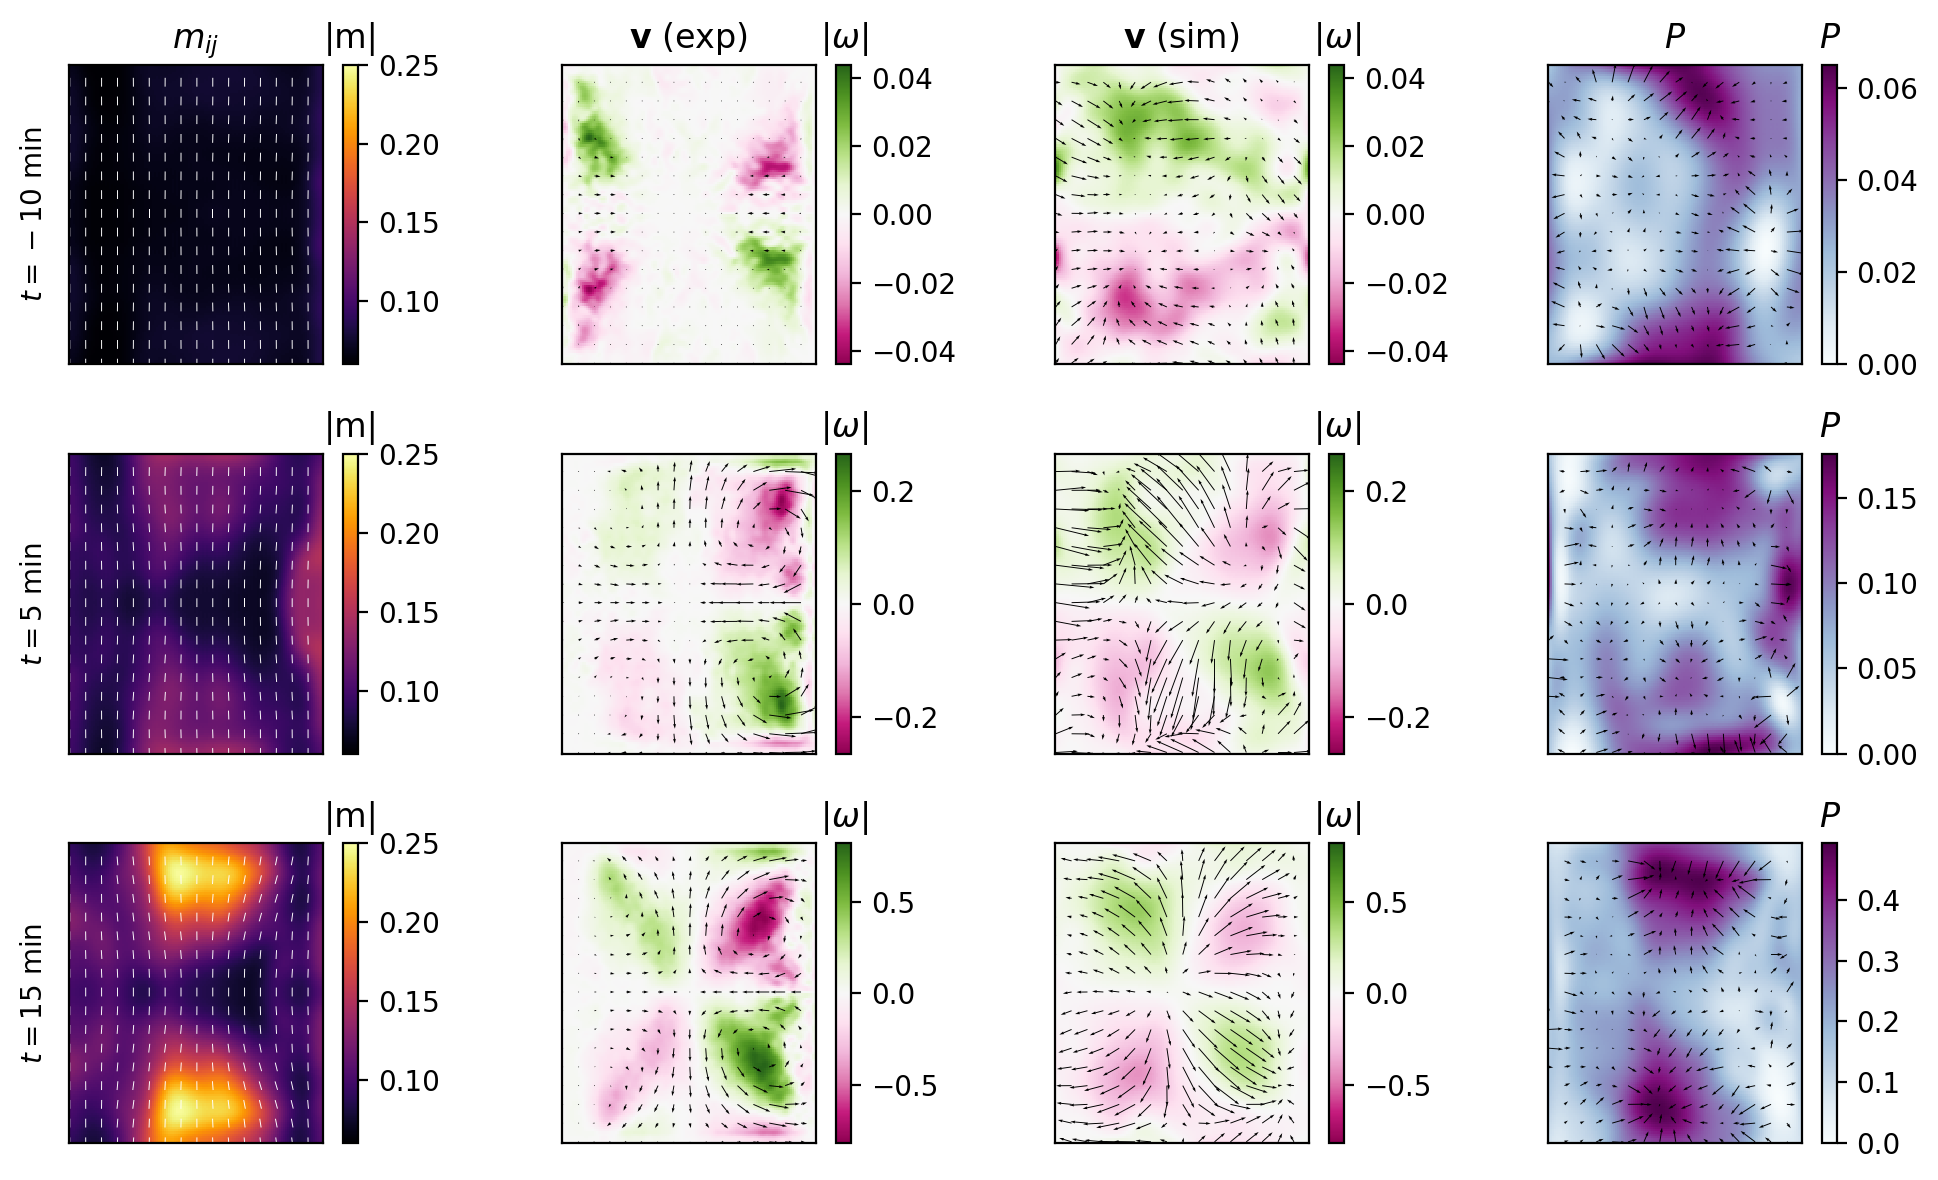

In [33]:
from scipy.interpolate import RectBivariateSpline
folder = '../../test_data'
tt = [0, 15, 25]
t0 = np.load(f'{folder}/time.npy')
print(f'Initial time = {t0[tt]}')
m0 = np.load(f'{folder}/myosin.npy', mmap_mode='r')[tt]
v0 = np.load(f'{folder}/velocity.npy', mmap_mode='r')[tt]
p0 = np.load('PINN_pressure.npy', mmap_mode='r')[tt]

logging.getLogger('subsystems').setLevel('ERROR')

def get_g_with_scales(field, scales):
    f = field.copy()
    f.change_scales(scales)
    return f["g"]

Lx, Ly = 452., 533.
Nx, Ny = 128, 128

dealias = 3/2
mu, α, B = 1, 3.237, 0.002

# Bases
coords = d3.CartesianCoordinates("x", "y")
dist = d3.Distributor(coords, dtype=np.float64)
xbasis = d3.RealFourier(  coords["x"], size=Nx, bounds=(-Lx/2,Lx/2), dealias=dealias)
ybasis = d3.RealFourier(coords["y"], size=Ny, bounds=(-Ly/2,Ly/2), dealias=dealias)
x1, y1 = dist.local_grids(xbasis, ybasis)
x0 = np.linspace(-Lx/2, Lx/2, m0.shape[-1])
y0 = np.linspace(-Ly/2, Ly/2, m0.shape[-2])
x = np.squeeze(xbasis.local_grid())
y = np.squeeze(ybasis.local_grid())

# Plot
fig, ax = plt.subplots(len(tt), 4, dpi=200, figsize=(10, 2*len(tt)))

# Forcing conditions
for i, t in enumerate(tt):
    # Fields
    v = dist.VectorField(coords, name="v", bases=(xbasis,ybasis))
    m = dist.TensorField(coords, name="m", bases=(xbasis,ybasis))
    p = dist.ScalarField(name='p', bases=(xbasis,ybasis))
    tau_v = dist.VectorField(coords, name='tau_v') #Residual for velocity
    
    m["g"][0,0,:,:] = RectBivariateSpline(x0, y0, m0[i, 3].T)(x1, y1)
    m["g"][0,1,:,:] = RectBivariateSpline(x0, y0, m0[i, 1].T)(x1, y1)
    m["g"][1,0,:,:] = m['g'][0,1,:,:]
    m["g"][1,1,:,:] = RectBivariateSpline(x0, y0, m0[i, 0].T)(x1, y1)
    p['g'][:] = RectBivariateSpline(x0, y0, p0[i].T)(x1, y1)
    vx = RectBivariateSpline(x0, y0, v0[i, 1].T)(x1, y1)
    vy = RectBivariateSpline(x0, y0, v0[i, 0].T)(x1, y1)

    #Static velocity Problem
    problem = d3.LBVP([v, tau_v], namespace=locals())
    problem.add_equation("mu*lap(v) + B*grad(div(v)) + tau_v = grad(p) - α * div(m) ") # Stokes equation (with tau residual)
    problem.add_equation("integ(v) = 0")   #No net flow gauge
    
    # Solver
    solver = problem.build_solver()
    solver.solve()

    pt = get_g_with_scales(p, (1, 1))
    vi = get_g_with_scales(v, (1, 1))
    mij = get_g_with_scales(m, (1, 1))

    mij = mij.transpose(2, 3, 0, 1)
    mkk = np.linalg.norm(mij, axis=(2, 3))
    el, ev = np.linalg.eigh(mij) #Positive eigenvalue is n
    n = ev[..., 1]

    pcM = ax[i, 0].pcolormesh(x, y, mkk.T, cmap='inferno', vmin=0.06, vmax=0.25)
    skip = 8
    scale = 1e2 if t0[t] > 10 else 2e1
    X, Y = np.meshgrid(x.flatten()[::skip], y.flatten()[::skip])
    ax[i, 0].quiver(X, Y, n[::skip, ::skip, 0].T, n[::skip, ::skip, 1].T,
                 pivot='middle', color='white',
                 headwidth=0, headlength=0, headaxislength=0)

    cb = plt.colorbar(pcM, ax=ax[i, 0])
    cb.ax.set_title("|m|")

    vort = np.gradient(vy, axis=-2) - np.gradient(vx, axis=-1)
    vmax = max(-vort.min(), vort.max())
    pcV = ax[i, 1].pcolormesh(x, y, vort.T, vmin=-vmax, vmax=vmax, cmap='PiYG')
    ax[i, 1].quiver(X, Y, vx[::skip, ::skip].T, vy[::skip, ::skip].T, 
                 color="black", scale=scale)
    cb = plt.colorbar(pcV, ax=ax[i, 1])
    cb.ax.set_title(r"$|\omega|$")

    vort = np.gradient(vi[1], axis=-2) - np.gradient(vi[0], axis=-1)
    pcV = ax[i, 2].pcolormesh(x, y, vort.T, vmin=-vmax, vmax=vmax, cmap='PiYG')
    ax[i, 2].quiver(X, Y, vi[0, ::skip, ::skip].T, vi[1, ::skip, ::skip].T, 
                 color="black", scale=scale)
    cb = plt.colorbar(pcV, ax=ax[i, 2])
    cb.ax.set_title(r"$|\omega|$")
    
    pcP = ax[i, 3].pcolormesh(x, y, (pt - pt.min()).T, cmap='BuPu')
    grad_p = np.stack([
        np.gradient(pt, axis=0),
        np.gradient(pt, axis=1)
    ])
    ax[i, 3].quiver(X, Y, grad_p[0, ::skip, ::skip].T, grad_p[1, ::skip, ::skip].T,
                    color='black')
    cb = plt.colorbar(pcP, ax=ax[i, 3])
    cb.ax.set_title(r"$P$")
    
    ax[i, 0].set_ylabel(f'$t = {t0[t]}$ min')

ax[0, 0].set_title(r'$m_{ij}$')
ax[0, 1].set_title(r'$\mathbf{v}$ (exp)')
ax[0, 2].set_title(r'$\mathbf{v}$ (sim)')
ax[0, 3].set_title(r'$P$')

for a in ax.flatten():
    a.set(xticks=[], yticks=[], aspect='equal')
    
plt.tight_layout()